In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

## Code for counting foundations within topic (pairs)

In [2]:
def count_foundation(data, cat, topic_1, topic_2=None, verdict=True,
                     YA=False, NA=False, verbose=False):
    assert (YA and NA) == False
    topic_df = data[data.topic_1 == topic_1]
    if topic_2 is not None:
        topic_df = data[((data.topic_1 == topic_1) & (data.topic_2 == topic_2)) |
                        ((data.topic_1 == topic_2) & (data.topic_2 == topic_1))]
    if YA:
        topic_df = topic_df[topic_df.YA > 0]
    elif NA:
        topic_df = topic_df[topic_df.NA > 0]
    if verdict and (not cat.startswith("v_")):
        cat = "v_" + cat
    total = topic_df.shape[0]
    count = np.sum(topic_df[cat])
    if verbose:
        print(count, total)
    return count, total

## Code for radar plotting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, **kwargs):
            self.set_thetagrids(np.degrees(theta), labels, **kwargs)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [4]:
def plot_radar(ya, na, ax):
    foundations = ["Authority", "Sanctity      ", "Loyalty", "Fairness", "Care"]
    data = [np.array([ya[0], ya[4], ya[3], ya[2], ya[1]]),
            np.array([na[0], na[4], na[3], na[2], na[1]])]

    N = 5
    theta = radar_factory(N, frame='polygon')

    colors = ['r', 'b', 'g', 'm', 'y']

    # Plot the four cases from the example data on separate axes
    case_data = data
    
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.2, label='_nolegend_')
    ax.set_varlabels(foundations, **{"size": 12, "linespacing": 2})

theta = radar_factory(5, frame='polygon')

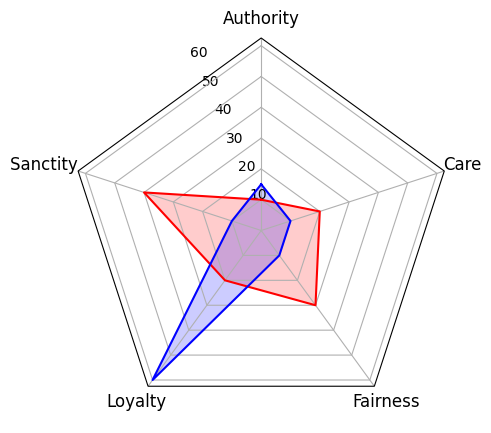

In [5]:
ya = [10, 20, 30, 20, 40]
na = [15, 10, 10, 60, 10]

fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1,
                       subplot_kw={"projection": "radar"})

plot_radar(ya=ya, na=na, ax=ax)

## Scored by RoBERTa

In [8]:
radar_data_roberta = pd.read_csv("data/aita/radar_plot_data/posts_and_verdicts_scored.csv")

In [9]:
radar_data_roberta.columns

Index(['_id', 'topic_1', 'topic_2', 'score', 'authority_score', 'care_score',
       'fairness_score', 'loyalty_score', 'sanctity_score', 'verdict',
       'verdict_id', 'YA', 'NA', 'v_authority_score', 'v_care_score',
       'v_fairness_score', 'v_loyalty_score', 'v_sanctity_score', 'authority',
       'v_authority', 'care', 'v_care', 'fairness', 'v_fairness', 'loyalty',
       'v_loyalty', 'sanctity', 'v_sanctity', 'mfd_count', 'v_mfd_count'],
      dtype='object')

### Transform scores to binary labels

In [12]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
for f in FOUNDATIONS:
    radar_data_roberta[f] = (radar_data_roberta[f + "_score"] >= 0.5).astype(int)
for f in FOUNDATIONS:
    radar_data_roberta["v_" + f] = (radar_data_roberta["v_" + f + "_score"] >= 0.5).astype(int)

### Count proportion of posts/verdicts with each foundation, for each topic (pair)

In [14]:
from tqdm import tqdm
topics = sorted(radar_data_roberta.topic_1.unique())
cats = ["care", "fairness", "loyalty", "authority", "sanctity"]
judgment_foundations = pd.DataFrame(0, columns=cats,
                                    index=[(topic, x) for topic in topics
                                           for x in ["YA", "NA"]])
post_foundations = pd.DataFrame(0, columns=cats,
                                index=[(topic, x) for topic in topics
                                       for x in ["YA", "NA"]])
for topic in tqdm(judgment_foundations.index):
    topic, x = topic
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations.columns:
        count, total = count_foundation(data=radar_data_roberta, 
                                        cat=cat, topic_1=topic,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        judgment_foundations.loc[[(topic, x)], cat] = count / total
        
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        post_foundations.loc[[(topic, x)], cat] = count / total

100%|██████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.75it/s]


In [15]:
topics = sorted(radar_data_roberta.topic_1.unique())
cats = FOUNDATIONS

topic_pairs = [(x, y) for x in topics for y in topics if x < y]
judgment_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
post_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
for pair in tqdm(judgment_foundations_pair.index):
    topic_1, topic_2, x = pair
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations_pair.columns:
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            judgment_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total
            
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            post_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total

100%|██████████████████████████████████████████████| 2162/2162 [13:22<00:00,  2.69it/s]


In [16]:
# Save results
post_foundations.to_csv("data/aita/radar_plot_data/post_foundations_roberta_0.5.csv")
judgment_foundations.to_csv("data/aita/radar_plot_data/judgment_foundations_roberta_0.5.csv")
post_foundations_pair.to_csv("data/aita/radar_plot_data/post_foundations_pair_roberta_0.5.csv")
judgment_foundations_pair.to_csv("data/aita/radar_plot_data/judgment_foundations_pair_roberta_0.5.csv")

### Load results and plot

In [32]:
import ast
post_foundations = pd.read_csv("data/aita/radar_plot_data/post_foundations_roberta_0.5.csv", index_col=0)
post_foundations.index = [ast.literal_eval(x) for x in post_foundations.index]

judgment_foundations = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_roberta_0.5.csv", index_col=0)
judgment_foundations.index = [ast.literal_eval(x) for x in judgment_foundations.index]

post_foundations_pair = pd.read_csv("data/aita/radar_plot_data/post_foundations_pair_roberta_0.5.csv", index_col=0)
post_foundations_pair.index = [ast.literal_eval(x) for x in post_foundations_pair.index]

judgment_foundations_pair = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_pair_roberta_0.5.csv", index_col=0)
judgment_foundations_pair.index = [ast.literal_eval(x) for x in judgment_foundations_pair.index]

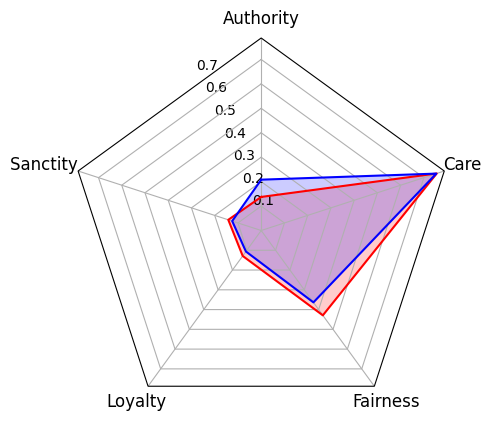

In [33]:
topic = "religion"
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
ya = post_foundations.loc[[(topic, "YA")], FOUNDATIONS].iloc[0].tolist()
na = post_foundations.loc[[(topic, "NA")], FOUNDATIONS].iloc[0].tolist()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='radar'))
plot_radar(ya=ya, na=na, ax=ax)

###  Setting threshold to xth percentile

In [13]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
total_scores = {f: np.array(list(radar_data_roberta[f + "_score"]) + 
                            list(radar_data_roberta["v_" + f + "_score"]))
                for f in FOUNDATIONS}
# Find thresholds
q = 80
thresholds = {}
for f in FOUNDATIONS:
    thresholds[f] = np.percentile(total_scores[f], q=q)
thresholds

{'authority': 0.24396249000000006,
 'care': 0.9262997199999999,
 'fairness': 0.584688128,
 'loyalty': 0.30730433200000007,
 'sanctity': 0.18631739200000003}

In [14]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
for f in FOUNDATIONS:
    radar_data_roberta[f] = (radar_data_roberta[f + "_score"] >= thresholds[f]).astype(int)
for f in FOUNDATIONS:
    radar_data_roberta["v_" + f] = (radar_data_roberta["v_" + f + "_score"] >= thresholds[f]).astype(int)

In [17]:
from tqdm import tqdm
topics = sorted(radar_data_roberta.topic_1.unique())
cats = ["care", "fairness", "loyalty", "authority", "sanctity"]
judgment_foundations = pd.DataFrame(0, columns=cats,
                                    index=[(topic, x) for topic in topics
                                           for x in ["YA", "NA"]])
post_foundations = pd.DataFrame(0, columns=cats,
                                index=[(topic, x) for topic in topics
                                       for x in ["YA", "NA"]])
for topic in tqdm(judgment_foundations.index):
    topic, x = topic
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations.columns:
        count, total = count_foundation(data=radar_data_roberta, 
                                        cat=cat, topic_1=topic,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        judgment_foundations.loc[[(topic, x)], cat] = count / total
        
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        post_foundations.loc[[(topic, x)], cat] = count / total

100%|██████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.84it/s]


In [18]:
topics = sorted(radar_data_roberta.topic_1.unique())
cats = FOUNDATIONS

topic_pairs = [(x, y) for x in topics for y in topics if x < y]
judgment_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
post_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
for pair in tqdm(judgment_foundations_pair.index):
    topic_1, topic_2, x = pair
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations_pair.columns:
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            judgment_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total
            
        count, total = count_foundation(data=radar_data_roberta,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            post_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total

100%|██████████████████████████████████████████████| 2162/2162 [12:30<00:00,  2.88it/s]


In [19]:
# Save results
post_foundations.to_csv("data/aita/radar_plot_data/post_foundations_roberta_80p.csv")
judgment_foundations.to_csv("data/aita/radar_plot_data/judgment_foundations_roberta_80p.csv")
post_foundations_pair.to_csv("data/aita/radar_plot_data/post_foundations_pair_roberta_80p.csv")
judgment_foundations_pair.to_csv("data/aita/radar_plot_data/judgment_foundations_pair_roberta_80p.csv")

In [20]:
import ast
post_foundations = pd.read_csv("data/aita/radar_plot_data/post_foundations_roberta_80p.csv", index_col=0)
post_foundations.index = [ast.literal_eval(x) for x in post_foundations.index]

judgment_foundations = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_roberta_80p.csv", index_col=0)
judgment_foundations.index = [ast.literal_eval(x) for x in judgment_foundations.index]

post_foundations_pair = pd.read_csv("data/aita/radar_plot_data/post_foundations_pair_roberta_80p.csv", index_col=0)
post_foundations_pair.index = [ast.literal_eval(x) for x in post_foundations_pair.index]

judgment_foundations_pair = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_pair_roberta_80p.csv", index_col=0)
judgment_foundations_pair.index = [ast.literal_eval(x) for x in judgment_foundations_pair.index]

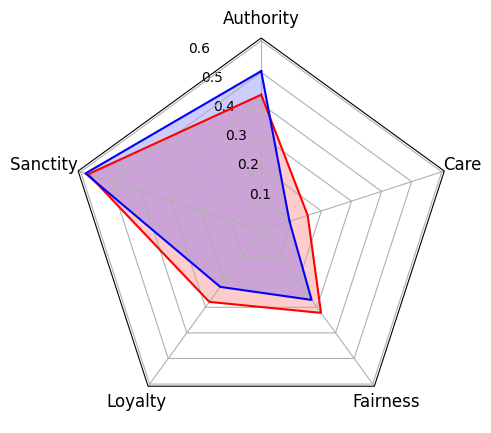

In [21]:
topic = "religion"
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
ya = post_foundations.loc[[(topic, "YA")], FOUNDATIONS].iloc[0].tolist()
na = post_foundations.loc[[(topic, "NA")], FOUNDATIONS].iloc[0].tolist()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='radar'))
plot_radar(ya=ya, na=na, ax=ax)

## Scored by MFD 2.0

### Aggregate the scores for posts and verdicts

In [17]:
radar_data_mfd2 = pd.read_csv("data/aita/radar_plot_data/radar_data_unscored.csv")
posts_mfd2 = pd.read_csv("data/aita/radar_plot_data/radar_data_posts_scored_mfd2.csv")
verdicts_mfd2 = pd.read_csv("data/aita/radar_plot_data/radar_data_verdicts_scored_mfd2.csv")

In [18]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
radar_data_mfd2[[f + "_score" for f in FOUNDATIONS]] = posts_mfd2[FOUNDATIONS]
radar_data_mfd2[["v_" + f + "_score" for f in FOUNDATIONS]] = verdicts_mfd2[FOUNDATIONS]

In [19]:
radar_data_mfd2.columns

Index(['_id', 'score', 'selftext', 'verdict_id', 'verdict_score', 'verdict',
       'YA', 'NA', 'topic_1', 'topic_2', 'authority_score', 'care_score',
       'fairness_score', 'loyalty_score', 'sanctity_score',
       'v_authority_score', 'v_care_score', 'v_fairness_score',
       'v_loyalty_score', 'v_sanctity_score'],
      dtype='object')

### Transform scores to binary labels

In [20]:
for f in FOUNDATIONS:
    radar_data_mfd2[f] = (radar_data_mfd2[f + "_score"] > 0).astype(int)
for f in FOUNDATIONS:
    radar_data_mfd2["v_" + f] = (radar_data_mfd2["v_" + f + "_score"] > 0).astype(int)

### Count proportion of posts/verdicts with each foundation, for each topic (pair)

In [22]:
from tqdm import tqdm
topics = sorted(radar_data_mfd2.topic_1.unique())
cats = ["care", "fairness", "loyalty", "authority", "sanctity"]
judgment_foundations = pd.DataFrame(0, columns=cats,
                                    index=[(topic, x) for topic in topics
                                           for x in ["YA", "NA"]])
post_foundations = pd.DataFrame(0, columns=cats,
                                index=[(topic, x) for topic in topics
                                       for x in ["YA", "NA"]])
for topic in tqdm(judgment_foundations.index):
    topic, x = topic
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations.columns:
        count, total = count_foundation(data=radar_data_mfd2, 
                                        cat=cat, topic_1=topic,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        judgment_foundations.loc[[(topic, x)], cat] = count / total
        
        count, total = count_foundation(data=radar_data_mfd2,
                                        cat=cat, topic_1=topic,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        post_foundations.loc[[(topic, x)], cat] = count / total

100%|██████████████████████████████████████████████████| 94/94 [00:10<00:00,  9.17it/s]


In [23]:
topics = sorted(radar_data_mfd2.topic_1.unique())
cats = FOUNDATIONS

topic_pairs = [(x, y) for x in topics for y in topics if x < y]
judgment_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
post_foundations_pair = pd.DataFrame(0, columns=cats,
                                    index=[(p[0], p[1], x) for p in topic_pairs
                                           for x in ["YA", "NA"]])
for pair in tqdm(judgment_foundations_pair.index):
    topic_1, topic_2, x = pair
    YA = x == "YA"
    NA = x == "NA"
    for cat in judgment_foundations_pair.columns:
        count, total = count_foundation(data=radar_data_mfd2,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=True, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            judgment_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total
            
        count, total = count_foundation(data=radar_data_mfd2,
                                        cat=cat, topic_1=topic_1, topic_2=topic_2,
                                        verdict=False, YA=YA, NA=NA,
                                        verbose=0)
        if total != 0:
            post_foundations_pair.loc[[(topic_1, topic_2, x)], cat] = count / total

100%|██████████████████████████████████████████████| 2162/2162 [13:28<00:00,  2.68it/s]


In [24]:
# Save results
post_foundations.to_csv("data/aita/radar_plot_data/post_foundations_mfd2.csv")
judgment_foundations.to_csv("data/aita/radar_plot_data/judgment_foundations_mfd2.csv")
post_foundations_pair.to_csv("data/aita/radar_plot_data/post_foundations_pair_mfd2.csv")
judgment_foundations_pair.to_csv("data/aita/radar_plot_data/judgment_foundations_pair_mfd2.csv")

### Load results and plot

In [30]:
import ast
post_foundations = pd.read_csv("data/aita/radar_plot_data/post_foundations_mfd2.csv", index_col=0)
post_foundations.index = [ast.literal_eval(x) for x in post_foundations.index]

judgment_foundations = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_mfd2.csv", index_col=0)
judgment_foundations.index = [ast.literal_eval(x) for x in judgment_foundations.index]

post_foundations_pair = pd.read_csv("data/aita/radar_plot_data/post_foundations_pair_mfd2.csv", index_col=0)
post_foundations_pair.index = [ast.literal_eval(x) for x in post_foundations_pair.index]

judgment_foundations_pair = pd.read_csv("data/aita/radar_plot_data/judgment_foundations_mfd2.csv", index_col=0)
judgment_foundations_pair.index = [ast.literal_eval(x) for x in judgment_foundations_pair.index]

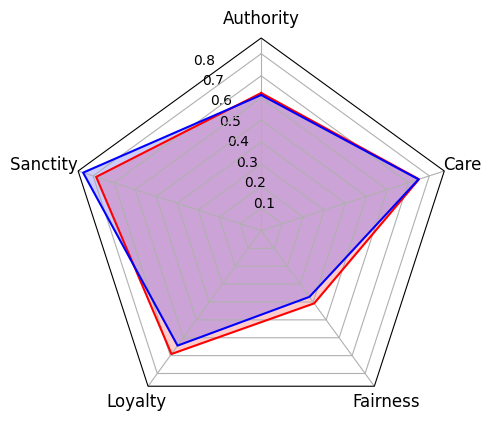

In [31]:
topic = "religion"
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
ya = post_foundations.loc[[(topic, "YA")], FOUNDATIONS].iloc[0].tolist()
na = post_foundations.loc[[(topic, "NA")], FOUNDATIONS].iloc[0].tolist()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='radar'))
plot_radar(ya=ya, na=na, ax=ax)